# SMOS Satellite Data
Lets try downloading some data from the ESA SMOS Catelogue, which has satellite data on soil moisture.

We first need to query their web serarch to know what files are available, then download one and explore it.

In [4]:
import pandas as pd
import numpy as np
from io import StringIO
from datetime import date
from urllib.parse import urlparse
import os

import requests             # For fetching web data
from ftplib import FTP_TLS  # For downloading files via ftp
from netCDF4 import Dataset # For opening the downloaded .nc files

First search the web catalog. This doesnt require authentication.

In [5]:
def search_catalogue(
    format='text/tab-separated-values',
    version='1.2',
    request="search",
    service='SimpleOnlineCatalogue',
    page_count=10,
    product_format='netCDF Format',
    product='MIR_SMUDP2',
    latitude_range=[50.0,51.0], # Start and end of latitude range.
    longitude_range=[-1,1],
    from_date=date(2021,1,1),
    to_date=date(2021,1,2),
):
    
    # Build a request to make to the search api.
    payload = {
        "format": format,
        "version": version,
        "request": request,
        "service": service,
        "pageCount": page_count,
        "query.nativeProductFormat": product_format,
        "query.productType": product,
    }

    if latitude_range:
        try:
            payload['query.footprint.minlat'], payload['query.footprint.maxlat'] = latitude_range
            payload['query.footprint.minlon'], payload['query.footprint.maxlon'] = longitude_range
        except (IndexError, TypeError, AttributeError) as err:
            print('You must specify both latitude and longitude ranges as tuples (min, max).')
            raise err

    payload['query.beginAcquisition.start'] = from_date.isoformat()
    payload['query.beginAcquisition.stop'] = to_date.isoformat()
    
    # Make our request
    r = requests.post("https://smos-diss.eo.esa.int/socat/SMOS_Open/search", data=payload, )
    assert r.status_code == 200, f"Got non-200 response. {r.status_code}: {r.text}"
    
    # Parse the tab delimeted data returned
    df = pd.read_table(StringIO(r.text))
    df['beginAcquisition'] = pd.to_datetime(df['beginAcquisition'])
    df['endAcquisition'] = pd.to_datetime(df['endAcquisition'])
    df['availabilityTime'] = pd.to_datetime(df['availabilityTime'])

    # Return the FTP filepath as a column, this might be a bit brittle
    # But it works for what I've fetched so far
    df['ftp_filepath'] = df.apply(
        lambda row: "/".join(
            [
                row['platformShortName'],
                "L2SM",
                row['productType'] + ("_nc" if product_format == "netCDF Format" else ""),
                row['beginAcquisition'].strftime("%Y/%m/%d"),
                row['productId']
            ], 

        ),
        axis='columns'
    )
    return df
    

files = search_catalogue(
    latitude_range=[50,51],
    longitude_range=[-1,1],
    from_date=date(2020,1,1,), 
    to_date=date(2020,2,1)
)
files.head()

,recordLastUpdate,beginAcquisition,endAcquisition,availabilityTime,platformShortName,platformSerialIdentifier,instrumentShortName,sensorType,operationalMode,orbitNumber,...,nativeProductFormat,fileClass,creationDate,ROI,dipFilename,productSize,processingCenter,processorVersion,processingLevel,ftp_filepath
0,2021-05-26T09:45:55Z,2020-01-16 04:48:26.090000+00:00,2020-01-16 05:41:46.525000+00:00,2020-01-16 05:41:46.525000+00:00,SMOS,1,MIRAS,other: RADIOMETER,FULL-DUAL,53630,...,netCDF Format,REPR,2021-01-24T17:29:41.000Z,NaN,SM_REPR_MIR_SMUDP2_20200116T044827_20200116T05...,8537298,ESAC,700,2,SMOS/L2SM/MIR_SMUDP2_nc/2020/01/16/SM_REPR_MIR...
1,2021-05-26T09:45:56Z,2020-01-15 17:58:01.659000+00:00,2020-01-15 18:51:17.294000+00:00,2020-01-15 18:51:17.294000+00:00,SMOS,1,MIRAS,other: RADIOMETER,FULL-DUAL,53624,...,netCDF Format,REPR,2021-01-24T16:05:29.000Z,NaN,SM_REPR_MIR_SMUDP2_20200115T175802_20200115T18...,6252832,ESAC,700,2,SMOS/L2SM/MIR_SMUDP2_nc/2020/01/15/SM_REPR_MIR...
2,2021-05-26T09:45:57Z,2020-01-01 18:43:13.646000+00:00,2020-01-01 19:36:28.081000+00:00,2020-01-01 19:36:28.081000+00:00,SMOS,1,MIRAS,other: RADIOMETER,FULL-DUAL,53423,...,netCDF Format,REPR,2021-01-23T19:39:58.000Z,NaN,SM_REPR_MIR_SMUDP2_20200101T184314_20200101T19...,6044293,ESAC,700,2,SMOS/L2SM/MIR_SMUDP2_nc/2020/01/01/SM_REPR_MIR...
3,2021-05-26T09:45:57Z,2020-01-31 05:04:19.751000+00:00,2020-01-31 05:57:40.188000+00:00,2020-01-31 05:57:40.188000+00:00,SMOS,1,MIRAS,other: RADIOMETER,FULL-DUAL,53846,...,netCDF Format,REPR,2021-01-25T17:11:38.000Z,NaN,SM_REPR_MIR_SMUDP2_20200131T050420_20200131T05...,7493485,ESAC,700,2,SMOS/L2SM/MIR_SMUDP2_nc/2020/01/31/SM_REPR_MIR...
4,2021-05-26T09:45:59Z,2020-01-29 18:52:53.650000+00:00,2020-01-29 19:46:09.287000+00:00,2020-01-29 19:46:09.287000+00:00,SMOS,1,MIRAS,other: RADIOMETER,FULL-DUAL,53826,...,netCDF Format,REPR,2021-01-25T14:31:33.000Z,NaN,SM_REPR_MIR_SMUDP2_20200129T185254_20200129T19...,5273856,ESAC,700,2,SMOS/L2SM/MIR_SMUDP2_nc/2020/01/29/SM_REPR_MIR...


Once we have a list of avialable files we want to download one and parse the data.

In [6]:
filepath = files.iloc[0]['ftp_filepath']
filename = files.iloc[0]['productId']


with FTP_TLS(
    host="smos-diss.eo.esa.int"
) as ftp:
    # Authenticate
    ftp.login(
        user=os.getenv('SMOS_USER'),
        passwd=os.getenv('SMOS_PASSWORD')
    )
    ftp.prot_p() #Makes sure we're using explicit TLS I think...

    with open(f"data/{filename}",'wb') as f:
        while f.tell() < ftp.size(filepath):
            if f.tell() == 0:
                ftp.retrbinary(f'RETR {filepath}', f.write)
            else:
                ftp.retrbinary(f'RETR {filepath}', f.write, f.tell())



In [10]:
data = Dataset(f"data/{filename}")

# Print the list of variables in the dataset
list(data.variables.keys())

['Surface_Temperature_DQX',
 'Scattering_Albedo_H',
 'Dielect_Const_MD_IM_DQX',
 'Tau_Cur_DQX',
 'M_AVA0',
 'DIFF_Albedos_DQX',
 'Latitude',
 'Roughness_Param_DQX',
 'TB_ASL_Theta_B_H_DQX',
 'DIFF_Albedos',
 'Dielect_Const_Non_MD_RE_DQX',
 'N_RFI_Y',
 'N_RFI_X',
 'RTT_DQX',
 'N_Sun_Tails',
 'DGG_Current_Flags',
 'Optical_Thickness_Nad_DQX',
 'N_Sun_Glint_Area',
 'Longitude',
 'GQX',
 'TB_TOA_Theta_B_H_DQX',
 'N_Calibration_Error',
 'Dielect_Const_Non_MD_RE',
 'Science_Flags',
 'N_RFI_Mitigations',
 'N_Wild',
 'TTH',
 'N_ADF_Error',
 'AFP',
 'N_Software_Error',
 'Dielect_Const_MD_IM',
 'Soil_Moisture_DQX',
 'Dielect_Const_Non_MD_IM',
 'RTT',
 'M_AVA',
 'Roughness_Param',
 'Processing_Flags',
 'Chi_2',
 'Days',
 'RFI_Prob',
 'Scattering_Albedo_H_DQX',
 'N_AF_FOV',
 'N_Sun_FOV',
 'TB_ASL_Theta_B_V',
 'Dielect_Const_Non_MD_IM_DQX',
 'TB_ASL_Theta_B_V_DQX',
 'S_Tree_1',
 'S_Tree_2',
 'X_Swath',
 'Chi_2_P',
 'Dielect_Const_MD_RE_DQX',
 'N_Sky',
 'N_Strong_RFI',
 'HR_Cur_DQX',
 'Confidence_Fl

Convert our dataset in netCDF format to a good old fashioned dataframe.

In [13]:
def dataset_to_df(dataset):
    lat = dataset.variables['Latitude'][:]
    lon = dataset.variables['Longitude'][:]
    moisture = [x.item() for x in dataset.variables['Soil_Moisture'][:]]
    return pd.DataFrame(list(zip(lat, lon, moisture)), columns=['lat','lon','soil_moisture'])


df = dataset_to_df(data)
df

,lat,lon,soil_moisture
0,-77.609001,39.090000,0.0
1,-77.721001,39.353001,0.0
2,-77.833000,39.622002,0.0
3,-77.716003,40.001999,0.0
4,-77.944000,39.895000,0.0
...,...,...,...
105950,75.169998,-92.163002,0.0
105951,75.338997,-93.355003,0.0
105952,75.237000,-92.995003,0.0
105953,75.136002,-92.639999,0.0


Then convert *that* dataframe into a `geopandas` dataframe.


In [76]:
import geopandas
import geoplot

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.lon, df.lat)
)

gdf.head()

,lat,lon,soil_moisture,geometry
0,-77.609001,39.090000,0.0,POINT (39.09000 -77.60900)
1,-77.721001,39.353001,0.0,POINT (39.35300 -77.72100)
2,-77.833000,39.622002,0.0,POINT (39.62200 -77.83300)
3,-77.716003,40.001999,0.0,POINT (40.00200 -77.71600)
4,-77.944000,39.895000,0.0,POINT (39.89500 -77.94400)


In [77]:
gdf.shape

(105955, 4)

Finally do a bit of plotting to see what we've got, we'll take a subset of the data that overlaps with europe.

In [73]:
# Load world outline
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
# Get just europe excluding russia.
europe = world[(world.continent == 'Europe') & (world.name != 'Russia')]


Lat Lon Bounds: [-24.32618405  34.9199877   40.08078902  80.65714427]
(25317, 4)


/opt/conda/lib/python3.9/site-packages/geoplot/geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


<AxesSubplot:>

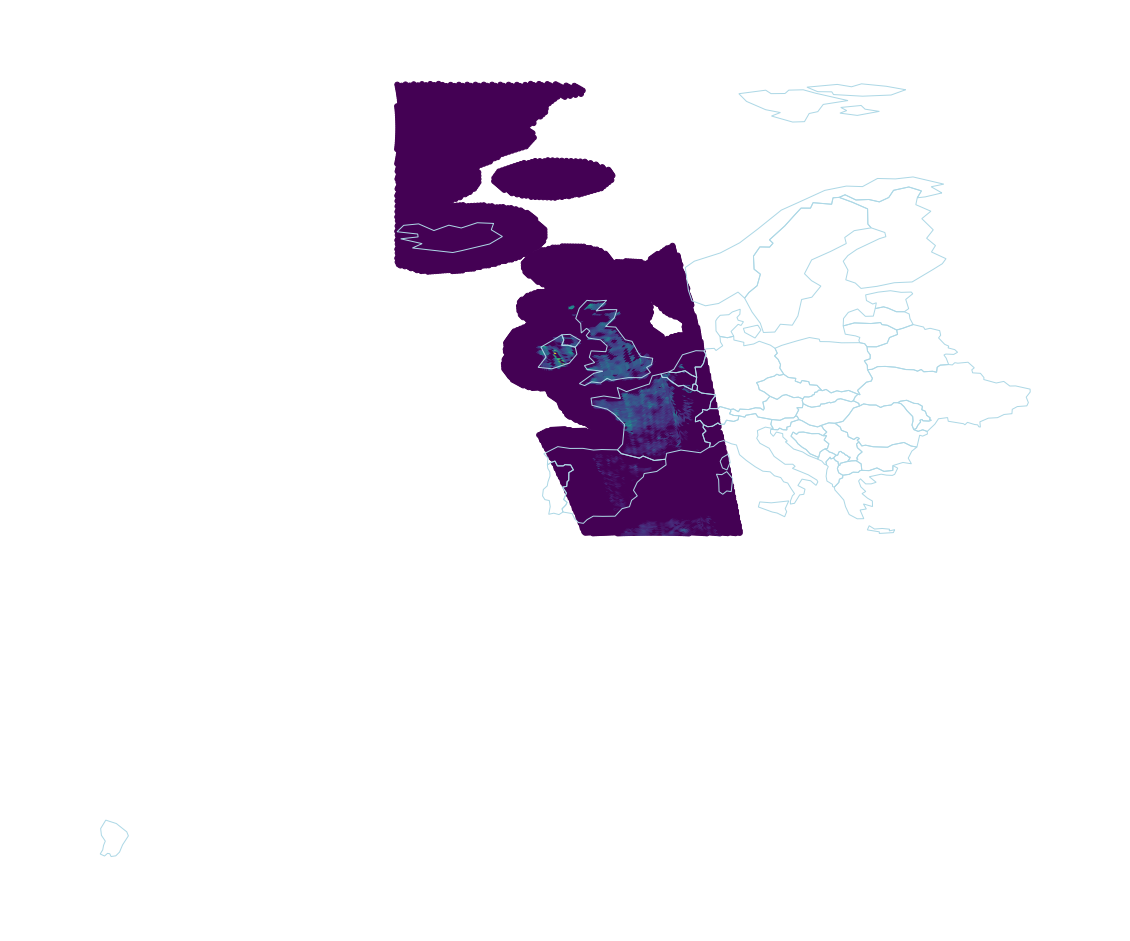

In [83]:
#Create plot for just europe
# Calculate bounding box by ignoring france, which includes french guyana.
extent = europe[europe.name != 'France'].total_bounds
print('Lat Lon Bounds:', extent)

gdf_europe = gdf[
    (gdf.lon > extent[0] ) & 
    (gdf.lon < extent[2]) &
    (gdf.lat > extent[1]) & 
    (gdf.lat < extent[3])
]
print(gdf_europe.shape)

ax = geoplot.pointplot(
    gdf_europe,
    hue='soil_moisture',
    figsize=(20,20),
    extent=gdf_europe.total_bounds
)

geoplot.polyplot(europe, ax=ax, zorder=1, edgecolor='lightblue')
